## Load Dependencies
The functions required to reproduce the workflow are located in the */utils* folder, and full function documentations are provided within the code. 

In [ ]:
from utils.preprocessing import *
from utils.L3Localization import *
from utils.slice_extraction import *

## Pre-processing

The workflow takes 3D CT volumetric scans as input (.nii or .nii.gz formats). The preprocessing steps perform maximum intensity projection (MIP) in the frontal and/or sagittal planes, and the resulting 2D images are thresholded for the bone intensity window (400 HU - 1500 HU) to increase constrast between the spine and soft tissues. Full documentation for preprocessing functions and methods can be found under *utils/preprocessing.py* and DHF8.1.1. Example CT volumes to reproduce the results of this vingette can be downloaded here: [Example Data](https://drive.google.com/drive/folders/1idxuRypn4kvKd5iHvm9in8scLPdFBxsP?usp=sharing)

<span style="color:red">**NOTE:** </span> The input volumes must be full abdominal CT scans, including the lower ribcage and upper pelvis. The L3 localization design does not currently support partial scans that only capture select areas of the abdomen. 

First, read in CT volumes as SimpleITK images:

In [ ]:
exam_path = "/Users/home/Documents/Capstone/GitHub/vingettes/example_data/volumes/0010.nii.gz"
sitk_image = sitk.ReadImage(exam_path)

Then, we perform MIP and HU thresholding, the visualize the results:

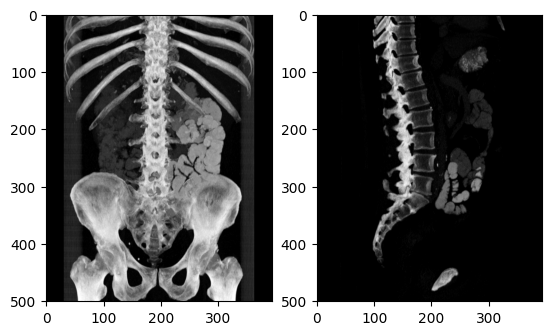

In [3]:
frontal_MIP = preprocess_CT_volume(sitk_image, mode = "frontal", threshold = True)
sagittal_MIP = preprocess_CT_volume(sitk_image, mode = "sagittal", threshold = True)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.flip(frontal_MIP), cmap = "gray")
axarr[1].imshow(np.flip(sagittal_MIP), cmap = "gray")

Save the MIPs as an [Ultralytics compatible image format](https://docs.ultralytics.com/modes/predict/#inference-sources) for use as inputs to the subsequent L3 localization. 

In [4]:
plt.imshow(frontal_MIP, cmap = 'gray')
plt.axis('off')
plt.imsave("/Users/home/Documents/Capstone/GitHub/vingettes/example_data/frontal_MIP.png", np.flip(frontal_MIP), cmap='gray')
plt.clf()

plt.imshow(sagittal_MIP, cmap = 'gray')
plt.axis('off')
plt.imsave("/Users/home/Documents/Capstone/GitHub/vingettes/example_data/sagittal_MIP.png", np.flip(sagittal_MIP), cmap='gray')
plt.clf()

<Figure size 640x480 with 0 Axes>

## L3 Vertebrae Localization from MIPs
A [YOLOv11](https://docs.ultralytics.com/models/yolo11/)-based approach is used to identify the coordinate of the center of the L3 vertebral body from frontal and sagittal MIPs. Methodology behind predicted bounding boxes and longitudinal L3 coordinate calculations can be found in *utils/L3Localization.py* and DHF8.1.2. 

First, we Load trained model weights (frontal and sagittal models), which can be downloaded here: [YOLO trained weights](https://drive.google.com/drive/folders/1x6G04jIU-igZgFdqlCwEcK8X4choPcqP?usp=sharing)

In [5]:
model_frontal = YOLO("/Users/home/Documents/Capstone/GitHub/vingettes/weights/best_frontal_l3localization.pt")
model_sagittal = YOLO("/Users/home/Documents/Capstone/GitHub/vingettes/weights/best_sagittal_l3localization.pt")

Using the models, we run predictions on the frontal and sagittal MIPs:

In [6]:
result_frontal = model_frontal("/Users/home/Documents/Capstone/GitHub/vingettes/example_data/frontal_MIP.png")
result_sagittal = model_sagittal("/Users/home/Documents/Capstone/GitHub/vingettes/example_data/sagittal_MIP.png")


image 1/1 /Users/home/Documents/Capstone/GitHub/vingettes/example_data/frontal_MIP.png: 640x512 1 box1-3, 1 box3-5, 9 transverse_processs, 295.3ms
Speed: 2.1ms preprocess, 295.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /Users/home/Documents/Capstone/GitHub/vingettes/example_data/sagittal_MIP.png: 640x512 1 L1, 1 L2, 1 L3, 1 L4, 1 L5, 2 T10s, 2 T11s, 2 T12s, 1 sacrum, 268.0ms
Speed: 1.4ms preprocess, 268.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


To ensure prediction quality, we can visualize and store prediction results from the frontal MIP. The function *get_L3_prediction* plots the bounding boxes and predicted L3 level, and returns the L3 coordinate along the longitudinal axis:

Frontal prediction: 219.36 mm


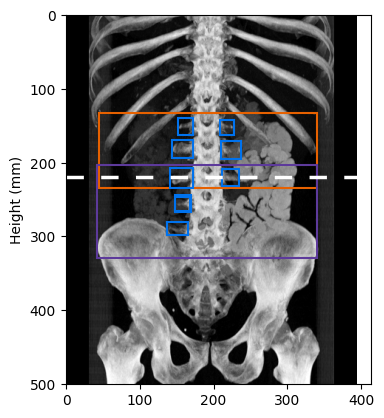

In [7]:
frontal_pred = get_L3_prediction(result_frontal, test_img = "/Users/home/Documents/Capstone/GitHub/vingettes/example_data/frontal_MIP.png", mode = "frontal")

Similarly, we will visualize and store prediction results on the sagittal MIP: 

Sagittal prediction: 220.99 mm


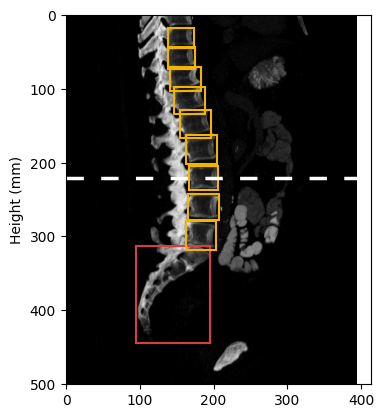

In [8]:
sagittal_pred = get_L3_prediction(result_sagittal, test_img = "/Users/home/Documents/Capstone/GitHub/vingettes/example_data/sagittal_MIP.png", mode = "sagittal")

## L3 Slice Extraction
Next, using the predicted L3 coordinate obtained from the frontal or sagittal view, we extract the corresponding CT slice—a cross-sectional image of the L3 vertebra - which will then be used for muscle segmentation. Methodology behind predicted bounding boxes and longitudinal L3 coordinate calculations can be found in *utils/slice_extraction.py* and DHF8.1.3. 

<span style="color:red">**NOTE 1:** </span> The slice is taken on the transverse plane, the muscle segmentation model might produce unreliable results if the patient's spine deviates significantly from a vertical orientation.

<span style="color:red">**NOTE 2:** </span> Here, the frontal and sagittal predictions are nearly identifcal and we use the predicted L3 level from the frontal MIP as an example. However, L3 prediction quality may differ between frontal and sagittal views depending on the scan. The workflow does not currently select the best prediction automatically - if your frontal and sagittal predictions differ significantly, please judge the best L3 coordinate.  

First, we retrieve the height and slice thickness of the original volume, then calculate the slice number that corresponds to the predicted L3 coordinate: 

In [ ]:
spacing = sitk_image.GetSpacing()
height = sitk_image.GetHeight()
L3_slice_index = slice_selection(frontal_pred, spacing, height)

Using the slice index, extract the L3 slice from the volume and visualize it with HU thresholding between -75 HU and +175 HU to enhance muscle constrast with the background: 

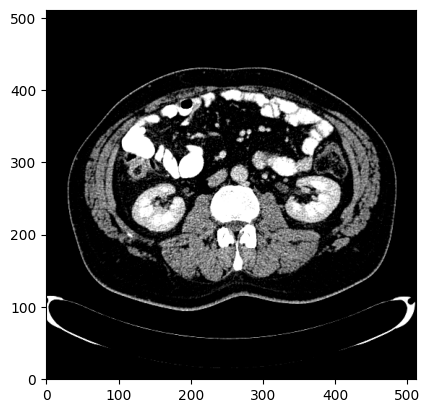

In [10]:
L3_slice_image = sitk.GetArrayFromImage(sitk_image)[L3_slice_index, :, :]
L3_slice_image = show_slice_window(L3_slice_image.T, level = 50, window = 250).T
plt.imshow(L3_slice_image, cmap="gray", origin="lower")

Lastly, save the thresholded slice image for use as input to the subsequent muscle segmentation model:

In [32]:
plt.imshow(L3_slice_image, cmap = 'gray')
plt.axis('off')
plt.imsave("/Users/home/Documents/Capstone/GitHub/vingettes/example_data/L3_slice.png", L3_slice_image, cmap='gray')
plt.clf()

<Figure size 640x480 with 0 Axes>